In [2]:
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import numpy
import networkx as nx


# Generating data

In [3]:
n,k = 2500,2
X = numpy.random.uniform(low=-100,high=100,size=(n,k))

In [4]:
y=(X[:,0]**2 + X[:,1]**2)**.5 < 60

In [5]:
X,X_test,y,y_test = train_test_split(X,y)

In [6]:
X.shape,X_test.shape

((1875, 2), (625, 2))

In [7]:
def PlotData(X,y):
    plt.scatter(x=X[:,0],y=X[:,1],c=y)    

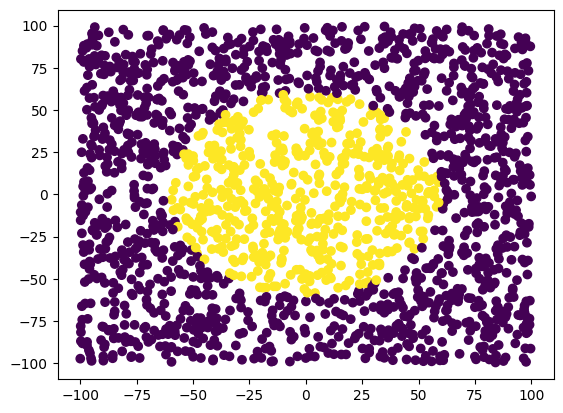

In [8]:
PlotData(X,y)

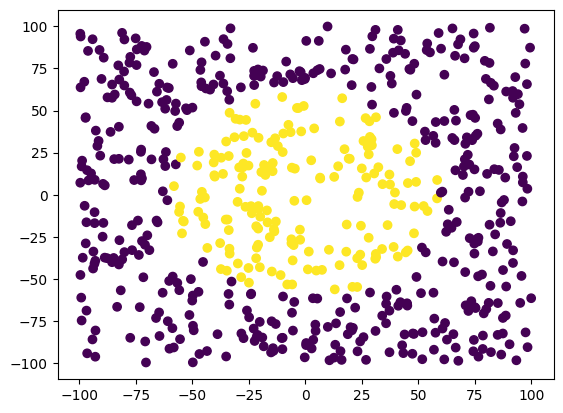

In [9]:
PlotData(X_test,y_test)

# Network Architechture
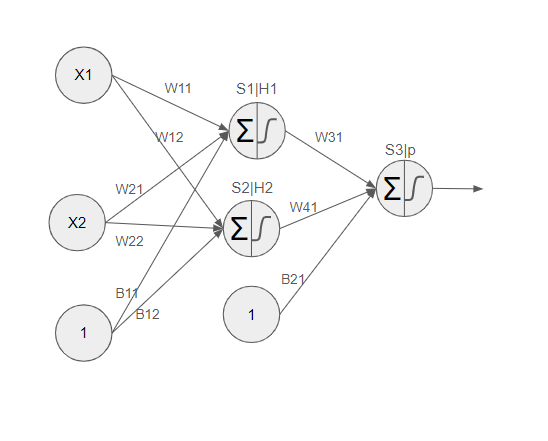

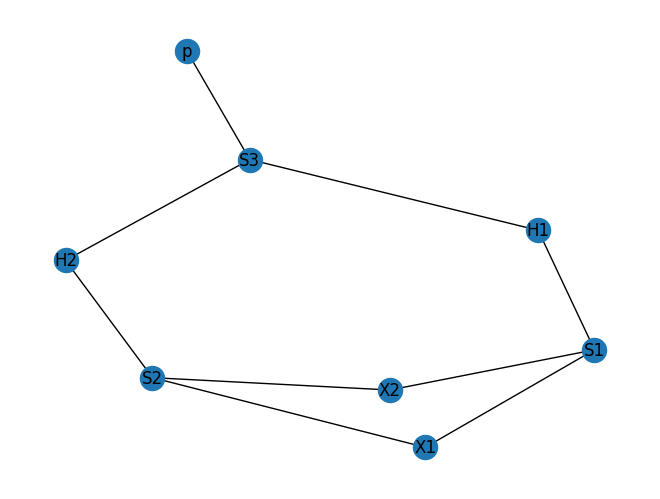

In [10]:
graph = {
    'S1':['X1','X2'],
    'S2':['X1','X2'],
    'H1':['S1'],
    'H2':['S2'],
    'S3':['H1','H2'],
    'p':['S3']
    
}
G = nx.Graph(graph)
nx.draw(G,with_labels=True)

In [11]:
class Σ:
    def __init__(self,In=None):
        self.In = In
    def eval(self):
        if not hasattr(self,'w'):
            self.w = numpy.zeros((self.In.shape[1]+1,1))
            self.b = numpy.ones((self.In.shape[0],1))
        self.out = numpy.c_[self.In,self.b].dot(self.w)
        return self.out
    def prime(self):
        self.pr = numpy.c_[self.In,self.b].mean(axis=0).reshape(-1,1)
        return self.pr
    def update(self,α,Δnext):
        self.Δ = self.prime()*Δnext
        self.w -= α*self.Δ
        return self.Δ

In [22]:
class σ:
    def __init__(self,In=None):
        self.In = In
    def eval(self):
        self.out = [1/(1+numpy.exp(-z)) for z in self.In]
        return self.out
    def prime(self):
        self.p = numpy.array([ (o*(1-o)).sum() for o in self.out]).reshape(-1,1)
        return self.p
    def update(self,α,Δnext):
        self.prime()
        self.Δ = [Δ[:len(self.p),:]*self.p for Δ in Δnext]
        return self.Δ    

In [13]:
class fullyconnected:
    def __init__(self,n_out,In=None):
        self.n_out = n_out
        self.__In = [Σ(In)]*self.n_out
    @property
    def In(self):
        return self.__In
    @In.setter
    def In(self,v):
        for s in self.__In:
            s.In = numpy.concatenate(v,axis=1)
    def __len__(self):
        return len(self.In)
    def eval(self):
        self.out = [v.eval() for v in self.In]
        return self.out
    def update(self,α,Δnext):
        self.Δ = [ I.update(α,Δnext[0][ix]) for ix,I in enumerate(self.In) ]
        return self.Δ    

# Backpropagation

## Sequential architecture

In [14]:
class Sequential:
    def __init__(self,steps):
        self.steps = steps
    def eval(self):
        self.steps[0].eval()
        self.out = self.steps[0].out
        for step in self.steps[1:]:
            step.In = self.out
            step.eval()
            self.out = step.out
        return self.out
    def update(self,α,Δnext):
        for step in self.steps[::-1]:
            Δnext = step.update(α,Δnext)
        return self

## Cost function

In [15]:
class binaryCrossEntropy:
    def __init__(self,y,p):
        self.y = y
        self.p = p.clip(1e-8)#for safety to avoid zero division error
    def eval(self):
        self.out = -(self.y*numpy.log(self.p) + (1-self.y)*numpy.log(1-self.p)).sum()
        return self.out
    def prime(self):
        self. pr = [-(self.y/self.p - (1-self.y)/(1-self.p)).sum(keepdims=True)]
        return self.pr

# Training

In [23]:
Model = Sequential([

        fullyconnected(n_out=2,In=(X-X.mean())/X.std()),
        σ(),

        fullyconnected(n_out=1),
        σ()

])
Model.eval()

[array([[0.5],
        [0.5],
        [0.5],
        ...,
        [0.5],
        [0.5],
        [0.5]])]

In [24]:
n_epochs = 2
α = .00001

for n in range(n_epochs):
    print(n)
    C = binaryCrossEntropy(y,Model.eval()[0]) 
    print('n=',n,'logloss=',C.eval())
    Model = Model.update(α,C.prime())

0
n= 0 logloss= 2436845.556656063
1
n= 1 logloss= 17856547.421631318


/tmp/ipykernel_462/3294087953.py:5: RuntimeWarning: overflow encountered in exp
  self.out = [1/(1+numpy.exp(-z)) for z in self.In]


In [18]:
Model.eval()[0]>.5

/tmp/ipykernel_462/3294087953.py:5: RuntimeWarning: overflow encountered in exp
  self.out = [1/(1+numpy.exp(-z)) for z in self.In]


array([[False],
       [False],
       [False],
       ...,
       [False],
       [False],
       [False]])